In [204]:
!pip install tensorflow -q
!pip install scikeras -q

In [233]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")
print('Success')

Success


In [207]:
# read data
data = pd.read_csv('survey_lung_cancer_synthetic.csv')
data.drop_duplicates(inplace = True)
print(data.shape)

(516, 16)


In [208]:
# encoding the categorical features
columns = data.columns.tolist()
columnsToEncode = [columns[0]] + columns[2:]
data['GENDER'] = data['GENDER'].replace(['M', 'F'], [1, 0])
data['LUNG_CANCER'] = data['LUNG_CANCER'].replace(['YES', 'NO'], [1, 0])
data[columnsToEncode[1:-1]] = data[columnsToEncode[1:-1]].replace({1: 0, 2: 1})
data

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,0,63,0,0,1,1,0,1,0,1,0,0,0,1,0,1
546,0,56,1,1,1,1,1,1,1,0,0,0,1,1,1,1
547,1,65,0,1,1,0,1,0,0,1,1,1,1,0,1,1
548,0,62,0,1,0,1,0,1,0,0,0,1,1,0,1,1


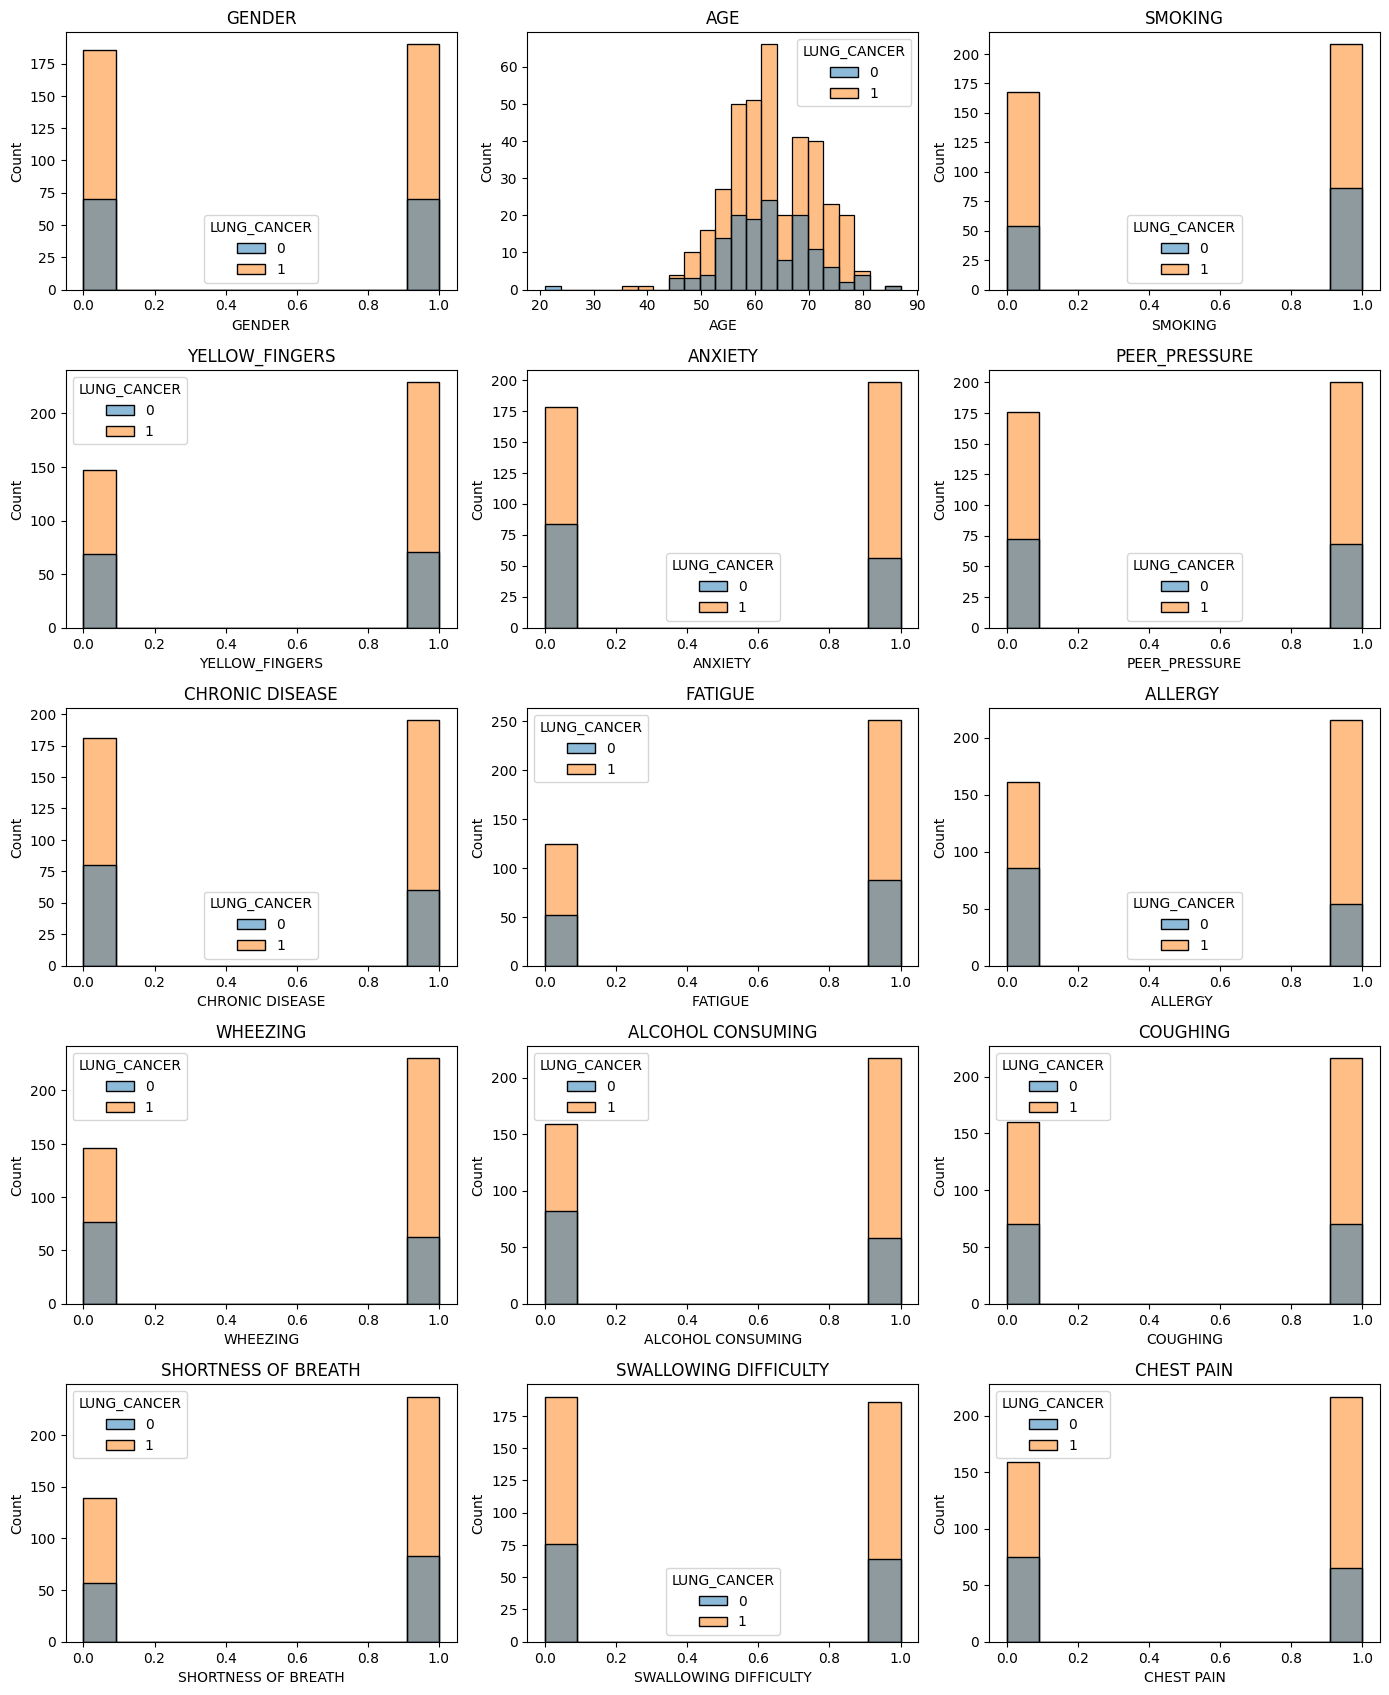

In [209]:
# data visualization
fig = plt.figure(figsize = (14, 20))
for i in range(len(columns)-1):
    plt.subplot(6, 3, i+1)
    plt.title(columns[i])
    sns.histplot(data = data, x = data[columns[i]], hue = 'LUNG_CANCER')
plt.tight_layout()

<Axes: title={'center': 'HEATMAP'}>

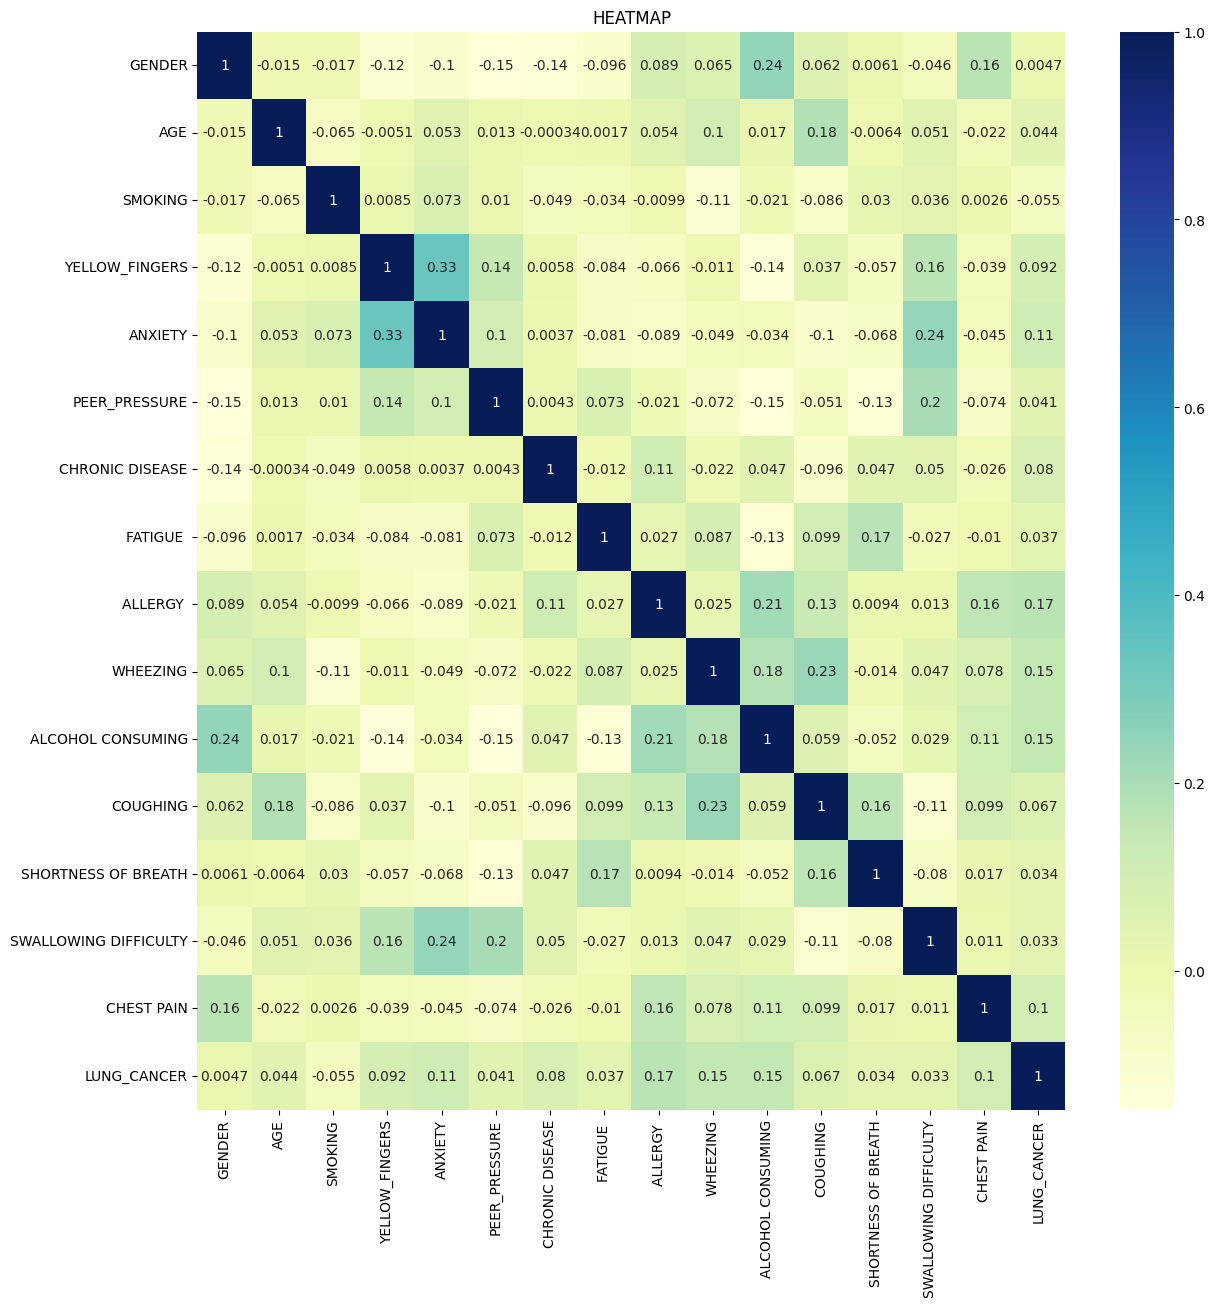

In [210]:
# heat map
f, ax = plt.subplots(1, 1, figsize = (14, 14))
plt.title('HEATMAP')
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu', ax=ax)

In [211]:
# splitting the features and target (test and train)
x = data.drop(['LUNG_CANCER'], axis = 1)
y = data['LUNG_CANCER']
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size = 0.2, random_state = 42)
title = []
cm = []
report = []

In [212]:
# Random Forest Classifier
rf = RandomForestClassifier()
z = 0
for i in range(10):
  rf.fit(x_train, y_train)
  y_pred = rf.predict(x_test)
  if z < accuracy_score(y_test, y_pred):
    z = accuracy_score(y_test, y_pred)
    rf_pred = y_pred

print(classification_report(y_test, rf_pred))
if 'Random Forest Classifier' not in title:
  title.append('Random Forest Classifier')
  cm.append(confusion_matrix(y_test, rf_pred))
  report.append(classification_report(y_test, rf_pred, output_dict=True))

              precision    recall  f1-score   support

           0       0.50      0.38      0.43        21
           1       0.85      0.90      0.88        83

    accuracy                           0.80       104
   macro avg       0.68      0.64      0.65       104
weighted avg       0.78      0.80      0.79       104



In [213]:
# Multi-Layer Perceptron Classifier
mlp = MLPClassifier()
z = 0
for i in range(10):
  mlp.fit(x_train, y_train)
  y_pred = mlp.predict(x_test)
  if z < accuracy_score(y_test, y_pred):
    z = accuracy_score(y_test, y_pred)
    mlp_pred = y_pred
print(classification_report(y_test, mlp_pred))

if 'Multi-Layer Perceptron' not in title:
  title.append('Multi-Layer Perceptron')
  cm.append(confusion_matrix(y_test, mlp_pred))
  report.append(classification_report(y_test, mlp_pred, output_dict=True))

              precision    recall  f1-score   support

           0       0.67      0.29      0.40        21
           1       0.84      0.96      0.90        83

    accuracy                           0.83       104
   macro avg       0.75      0.62      0.65       104
weighted avg       0.81      0.83      0.80       104



In [214]:
# Long Short-Term Memory
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = x_scaled.reshape((x_scaled.shape[0], 1, x_scaled.shape[1]))
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

# LSTM model
model = Sequential([
    LSTM(64, input_shape=(1, x_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

# Evaluation
lstm_pred = (model.predict(x_test) > 0.5).astype("int32")
print(classification_report(y_test, lstm_pred))
if 'Long Short-Term Memory' not in title:
  title.append('Long Short-Term Memory')
  cm.append(confusion_matrix(y_test, lstm_pred))
  report.append(classification_report(y_test, lstm_pred, output_dict=True))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
              precision    recall  f1-score   support

           0       0.37      0.33      0.35        21
           1       0.84      0.86      0.85        83

    accuracy                           0.75       104
   macro avg       0.60      0.59      0.60       104
weighted avg       0.74      0.75      0.75       104



In [215]:
# new features
featureData = data.copy()

risk_factors = ['ALLERGY ', 'WHEEZING', 'ALCOHOL CONSUMING', 'COUGHING', 'SWALLOWING DIFFICULTY']
featureData['RISK_SCORE'] = featureData[risk_factors].sum(axis=1)

featureData['SMOKE_ALCOHOL'] = featureData['SMOKING'] & featureData['ALCOHOL CONSUMING']
featureData['AGE_GROUP'] = pd.cut(featureData['AGE'], bins=[0, 40, 60, 100], labels=[0, 1, 2]).astype(int)

symptoms = ['COUGHING', 'CHEST PAIN', 'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY']
featureData['PHYSICAL_SYMPTOMS_COUNT'] = featureData[symptoms].sum(axis=1)
featureData['MENTAL_HEALTH_SCORE'] = featureData['ANXIETY'] + featureData['PEER_PRESSURE']

featureData.drop('AGE', axis=1, inplace=True)
newColumns = featureData.columns.tolist()
newColumns

['GENDER',
 'SMOKING',
 'YELLOW_FINGERS',
 'ANXIETY',
 'PEER_PRESSURE',
 'CHRONIC DISEASE',
 'FATIGUE ',
 'ALLERGY ',
 'WHEEZING',
 'ALCOHOL CONSUMING',
 'COUGHING',
 'SHORTNESS OF BREATH',
 'SWALLOWING DIFFICULTY',
 'CHEST PAIN',
 'LUNG_CANCER',
 'RISK_SCORE',
 'SMOKE_ALCOHOL',
 'AGE_GROUP',
 'PHYSICAL_SYMPTOMS_COUNT',
 'MENTAL_HEALTH_SCORE']

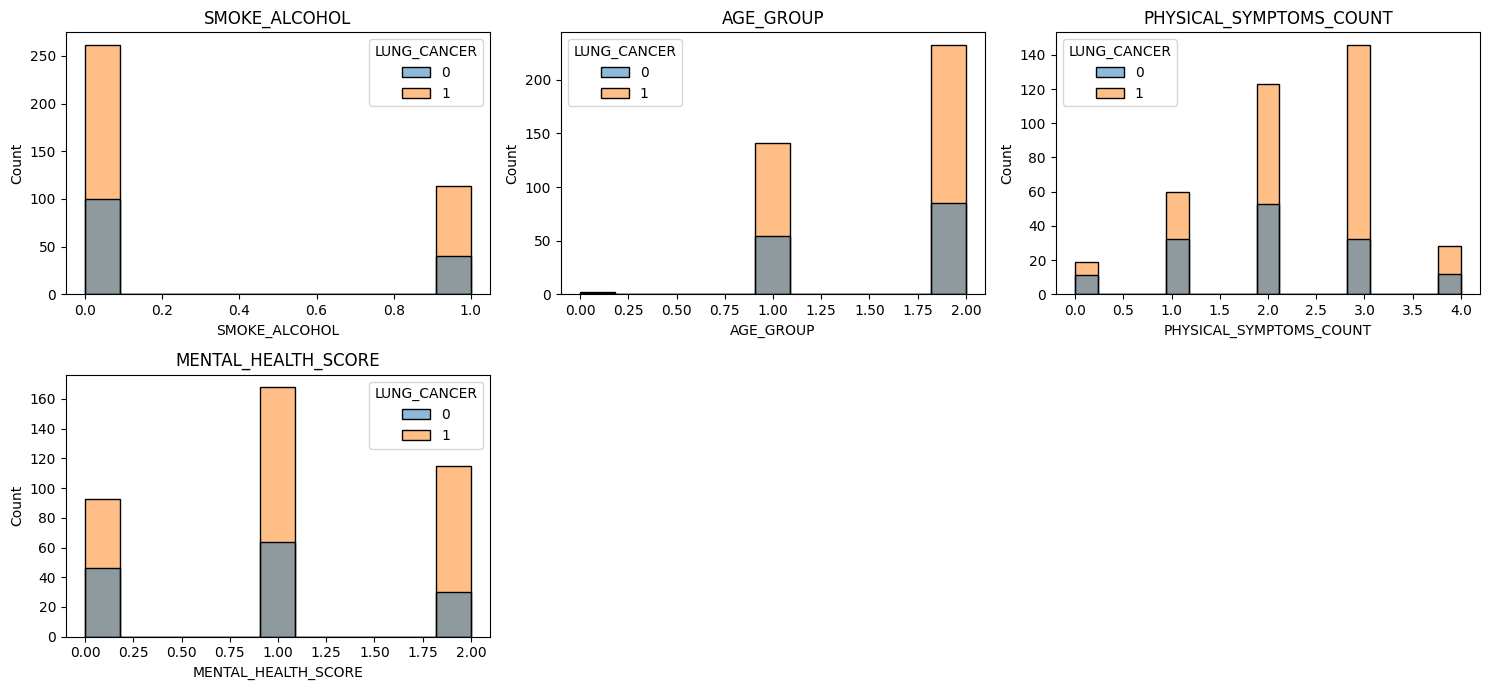

In [216]:
# data visualization
fig = plt.figure(figsize = (15, 7))
for i in range(16, len(newColumns)):
    plt.subplot(2, 3, i-15)
    plt.title(newColumns[i])
    sns.histplot(data = featureData, x = featureData[newColumns[i]], hue = 'LUNG_CANCER')
plt.tight_layout()

<Axes: title={'center': 'HEATMAP'}>

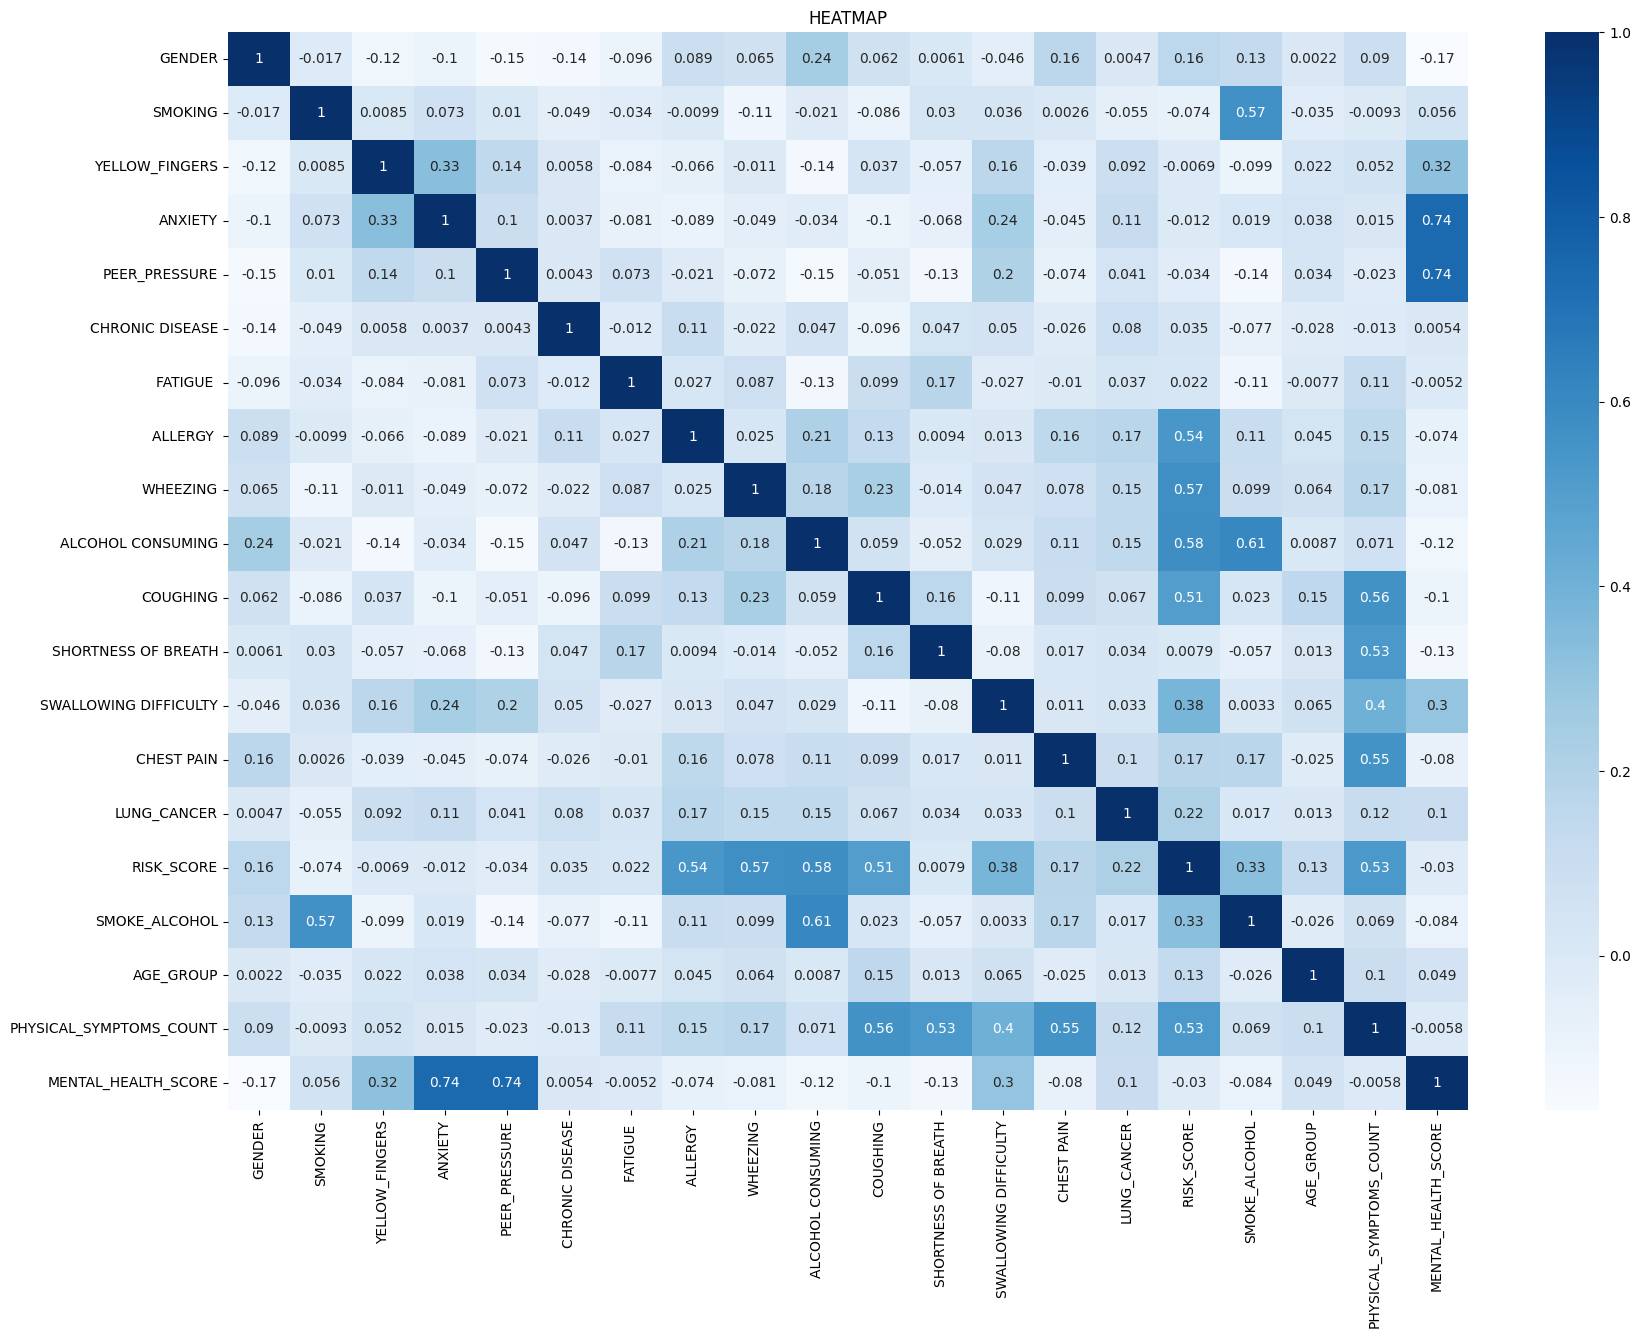

In [217]:
# heat map
f, ax = plt.subplots(1, 1, figsize = (20, 14))
plt.title('HEATMAP')
sns.heatmap(featureData.corr(), annot=True, cmap='Blues', ax=ax)

In [272]:
# MLP (features)
X = featureData.drop('LUNG_CANCER', axis=1)
y = featureData['LUNG_CANCER']
label_encoder = LabelEncoder()

for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

if y.dtype == 'object':
    y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50),
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=42,
                    early_stopping=True,
                    validation_fraction=0.1)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))
if 'MLP (New Features)' not in title:
  title.append('MLP (New Features)')
  cm.append(confusion_matrix(y_test, y_pred))
  report.append(classification_report(y_test, y_pred, output_dict=True))

              precision    recall  f1-score   support

           0       0.86      0.27      0.41        22
           1       0.84      0.99      0.91        82

    accuracy                           0.84       104
   macro avg       0.85      0.63      0.66       104
weighted avg       0.84      0.84      0.80       104



In [278]:
# MLP (features extend)
newData = featureData.copy()
newData = newData[:-100]
X = newData.drop('LUNG_CANCER', axis=1)
y = newData['LUNG_CANCER']
label_encoder = LabelEncoder()

for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

if y.dtype == 'object':
    y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50),
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=42,
                    early_stopping=True,
                    validation_fraction=0.1)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.27      0.40        11
           1       0.90      0.99      0.94        73

    accuracy                           0.89        84
   macro avg       0.82      0.63      0.67        84
weighted avg       0.88      0.89      0.87        84



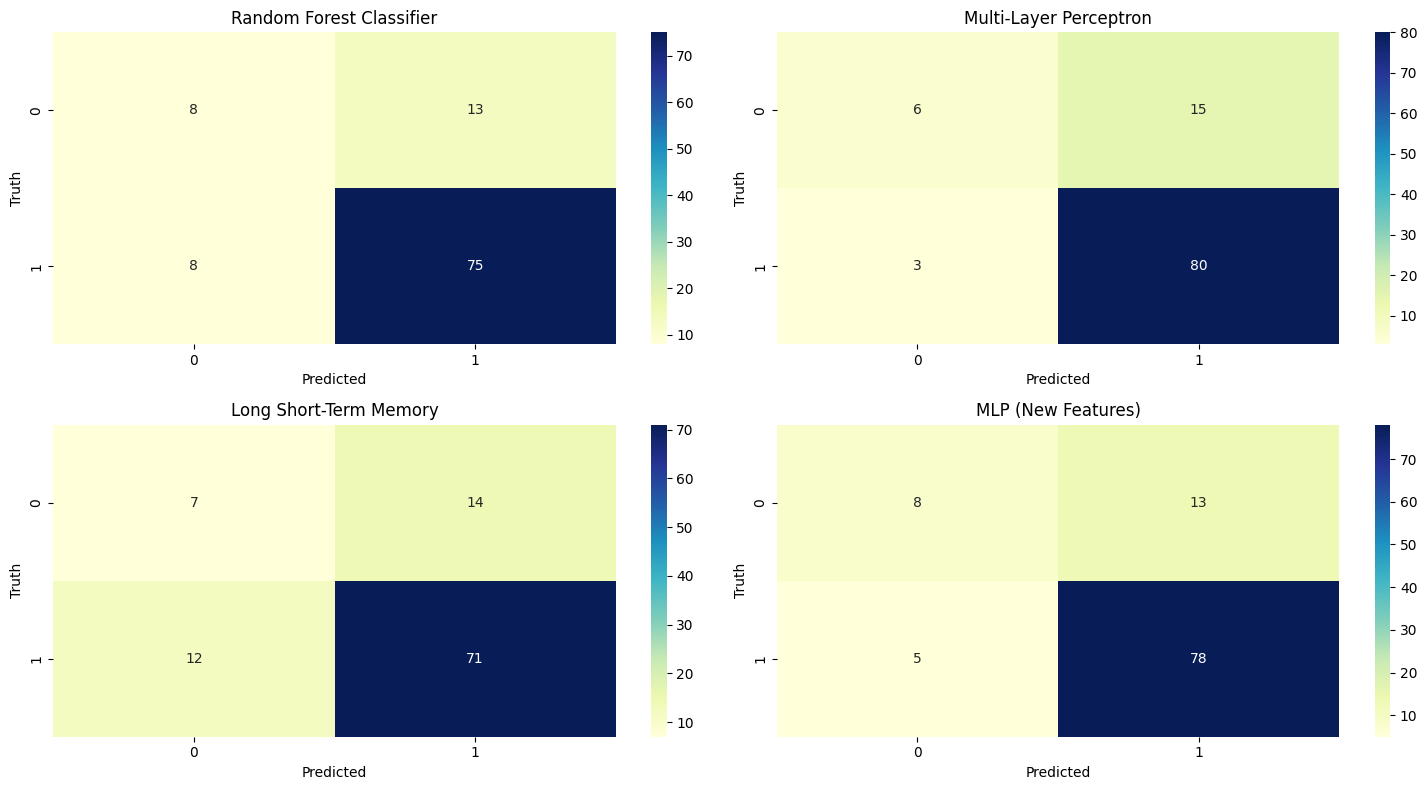

In [243]:
# confusion matrix heatmaps
fig = plt.figure(figsize = (15, 8))
for i in range(len(title)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    sns.heatmap(cm[i], annot = True, cmap='YlGnBu')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
plt.tight_layout()

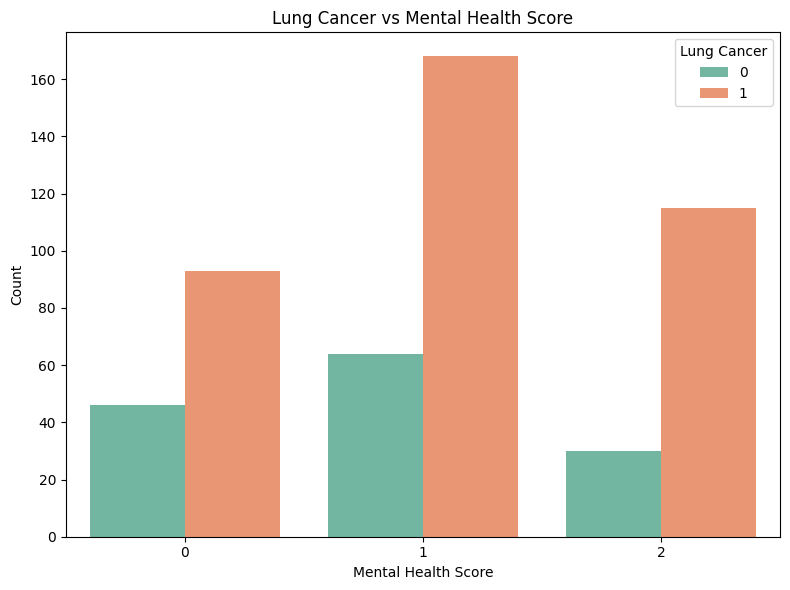

In [244]:
# Mental Health Score Prediction
mentalData = featureData.drop(['ANXIETY', 'PEER_PRESSURE'], axis=1)
x = mentalData.drop(['MENTAL_HEALTH_SCORE'], axis=1)
y = mentalData['MENTAL_HEALTH_SCORE']

plt.figure(figsize=(8, 6))
sns.countplot(data=mentalData, x='MENTAL_HEALTH_SCORE', hue='LUNG_CANCER', palette='Set2')
plt.title('Lung Cancer vs Mental Health Score')
plt.xlabel('Mental Health Score')
plt.ylabel('Count')
plt.legend(title='Lung Cancer')
plt.tight_layout()
plt.show()

In [245]:
# Random Forest Classifier
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 87)
rf = RandomForestClassifier()
z = 0
for i in range(10):
  rf.fit(x_train, y_train)
  y_pred = rf.predict(x_test)
  if z < accuracy_score(y_test, y_pred):
    z = accuracy_score(y_test, y_pred)
    rfc_pred = y_pred

print(classification_report(y_test, rfc_pred, labels=[0, 1, 2]))
if 'Random Forest (Mental Health)' not in title:
    title.append('Random Forest (Mental Health)')
    cm.append(confusion_matrix(y_test, rfc_pred, labels=[0, 1, 2]))
    report.append(classification_report(y_test, rfc_pred, labels=[0, 1, 2], output_dict=True))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78        25
           1       0.75      0.88      0.81        50
           2       0.86      0.62      0.72        29

    accuracy                           0.78       104
   macro avg       0.80      0.75      0.77       104
weighted avg       0.79      0.78      0.78       104



In [246]:
#LSTM
label_encoders = {}
for col in mentalData.select_dtypes(include='object').columns:
    le = LabelEncoder()
    mentalData[col] = le.fit_transform(mentalData[col])
    label_encoders[col] = le

# Split features and target
X = mentalData.drop('MENTAL_HEALTH_SCORE', axis=1)
y = mentalData['MENTAL_HEALTH_SCORE']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # 3 classes: 0, 1, 2

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Print classification report
print(classification_report(y_test, y_pred))
if 'LSTM (Mental Health)' not in title:
  title.append('LSTM (Mental Health)')
  cm.append(confusion_matrix(y_test, y_pred))
  report.append(classification_report(y_test, y_pred, output_dict=True))

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.4108 - loss: 1.0970 - val_accuracy: 0.4578 - val_loss: 1.0901
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4960 - loss: 1.0808 - val_accuracy: 0.4699 - val_loss: 1.0827
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4839 - loss: 1.0738 - val_accuracy: 0.4578 - val_loss: 1.0749
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4924 - loss: 1.0660 - val_accuracy: 0.4699 - val_loss: 1.0670
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4557 - loss: 1.0592 - val_accuracy: 0.4699 - val_loss: 1.0569
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4833 - loss: 1.0394 - val_accuracy: 0.4578 - val_loss: 1.0455
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4767 - loss: 1.0233 - val_accuracy: 0.4578 - val_loss: 1.0343
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5072 - loss: 1.0023 - val_accuracy: 0.4578 - v

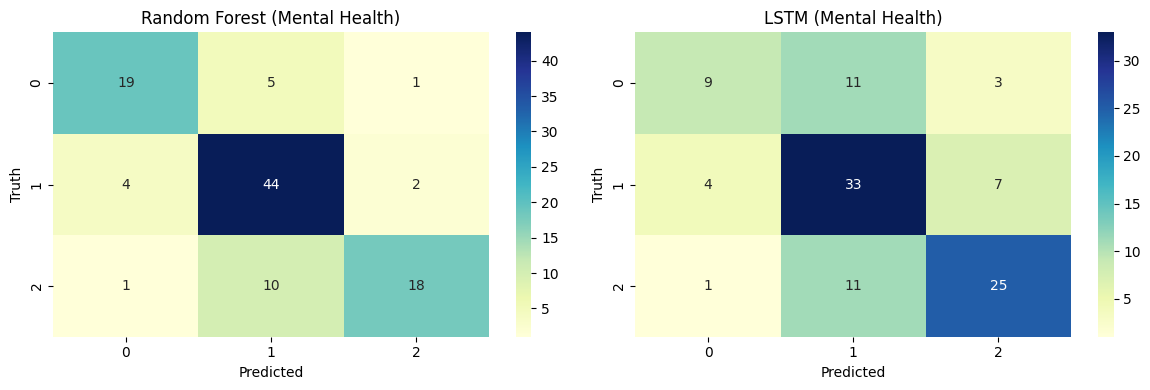

In [247]:
# confusion matrix heatmaps
fig = plt.figure(figsize = (12, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i+4])
    sns.heatmap(cm[i+4], annot = True, cmap='YlGnBu')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
plt.tight_layout()

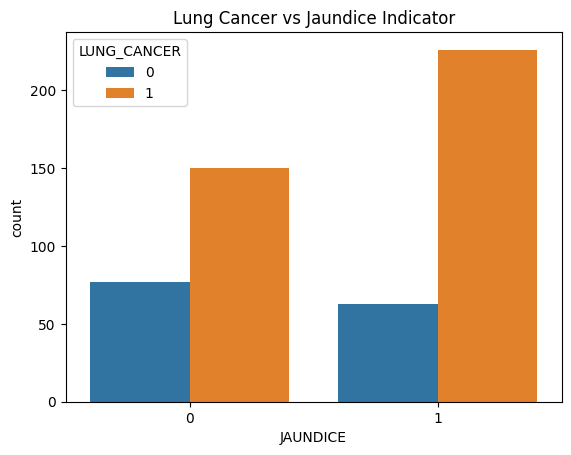

In [248]:
# Jaundice
jaundiceData = data.copy()
jaundiceData['JAUNDICE'] = (
    jaundiceData['ALCOHOL CONSUMING'] +
    jaundiceData['CHRONIC DISEASE'] +
    jaundiceData['YELLOW_FINGERS']
)
jaundiceData['JAUNDICE'] = jaundiceData['JAUNDICE'].apply(lambda x: 1 if x >= 2 else 0)
jaundiceData.drop(['ALCOHOL CONSUMING', 'CHRONIC DISEASE', 'YELLOW_FINGERS'], axis=1, inplace=True)

sns.countplot(data=jaundiceData, x='JAUNDICE', hue='LUNG_CANCER')
plt.title('Lung Cancer vs Jaundice Indicator')
plt.show()

In [249]:
# Random Forest Classifier
x = jaundiceData.drop(['JAUNDICE'], axis = 1)
y = jaundiceData['JAUNDICE']
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size = 0.2, random_state = 42)

rf = RandomForestClassifier()
z = 0
for i in range(10):
  rf.fit(x_train, y_train)
  y_pred = rf.predict(x_test)
  if z < accuracy_score(y_test, y_pred):
    z = accuracy_score(y_test, y_pred)
    rf_pred = y_pred

print(classification_report(y_test, rf_pred))
if 'Random Forest (Jaundice)' not in title:
  title.append('Random Forest (Jaundice)')
  cm.append(confusion_matrix(y_test, rf_pred))
  report.append(classification_report(y_test, rf_pred, output_dict=True))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        41
           1       0.85      0.84      0.85        63

    accuracy                           0.82       104
   macro avg       0.81      0.81      0.81       104
weighted avg       0.82      0.82      0.82       104



In [250]:
# MLP
mlp = MLPClassifier()
z = 0
for i in range(10):
  mlp.fit(x_train, y_train)
  y_pred = mlp.predict(x_test)
  if z < accuracy_score(y_test, y_pred):
    z = accuracy_score(y_test, y_pred)
    mlp_pred = y_pred

print(classification_report(y_test, mlp_pred))
if 'MLP (Jaundice)' not in title:
  title.append('MLP (Jaundice)')
  cm.append(confusion_matrix(y_test, mlp_pred))
  report.append(classification_report(y_test, mlp_pred, output_dict=True))

              precision    recall  f1-score   support

           0       0.91      0.24      0.38        41
           1       0.67      0.98      0.79        63

    accuracy                           0.69       104
   macro avg       0.79      0.61      0.59       104
weighted avg       0.76      0.69      0.63       104



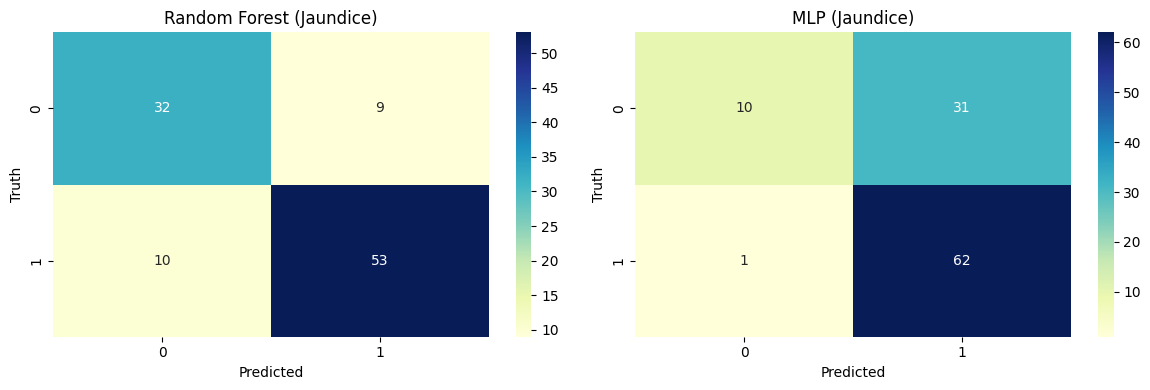

In [251]:
# confusion matrix heatmaps
fig = plt.figure(figsize = (12, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i+6])
    sns.heatmap(cm[i+6], annot = True, cmap='YlGnBu')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
plt.tight_layout()

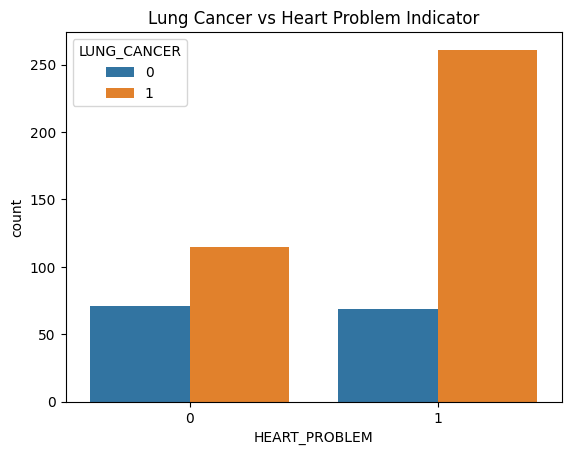

In [257]:
# Heart problem
heartData = featureData.copy()
heartData.drop('RISK_SCORE', axis=1, inplace=True)

heartData['HEART_PROBLEM'] = (
    heartData['SMOKING'] +
    heartData['ANXIETY'] +
    heartData['PEER_PRESSURE'] +
    heartData['CHRONIC DISEASE'] +
    heartData['FATIGUE '] +
    heartData['ALLERGY '] +
    heartData['WHEEZING'] +
    heartData['ALCOHOL CONSUMING'] +
    heartData['COUGHING'] +
    heartData['CHEST PAIN'] +
    heartData['SHORTNESS OF BREATH']
)

heartData['HEART_PROBLEM'] = heartData['HEART_PROBLEM'].apply(lambda x: 1 if x >= 6 else 0)
sns.countplot(data=heartData, x='HEART_PROBLEM', hue='LUNG_CANCER')
plt.title('Lung Cancer vs Heart Problem Indicator')
plt.show()

In [258]:
# Random Forest Classifier
x = heartData.drop(['HEART_PROBLEM'], axis = 1)
y = heartData['HEART_PROBLEM']
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size = 0.2, random_state = 42)

rf = RandomForestClassifier()
z = 0
for i in range(10):
  rf.fit(x_train, y_train)
  y_pred = rf.predict(x_test)
  if z < accuracy_score(y_test, y_pred):
    z = accuracy_score(y_test, y_pred)
    rf_pred = y_pred

print(classification_report(y_test, rf_pred))
if 'Random Forest (Heart Problem)' not in title:
  title.append('Random Forest (Heart Problem)')
  cm.append(confusion_matrix(y_test, rf_pred))
  report.append(classification_report(y_test, rf_pred, output_dict=True))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89        33
           1       0.94      0.96      0.95        71

    accuracy                           0.93       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.93      0.93      0.93       104



In [259]:
# MLP
mlp = MLPClassifier()
z = 0
for i in range(10):
  mlp.fit(x_train, y_train)
  y_pred = mlp.predict(x_test)
  if z < accuracy_score(y_test, y_pred):
    z = accuracy_score(y_test, y_pred)
    mlp_pred = y_pred

print(classification_report(y_test, mlp_pred))
if 'MLP (Heart Problem)' not in title:
  title.append('MLP (Heart Problem)')
  cm.append(confusion_matrix(y_test, mlp_pred))
  report.append(classification_report(y_test, mlp_pred, output_dict=True))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90        33
           1       0.96      0.94      0.95        71

    accuracy                           0.93       104
   macro avg       0.92      0.93      0.92       104
weighted avg       0.93      0.93      0.93       104



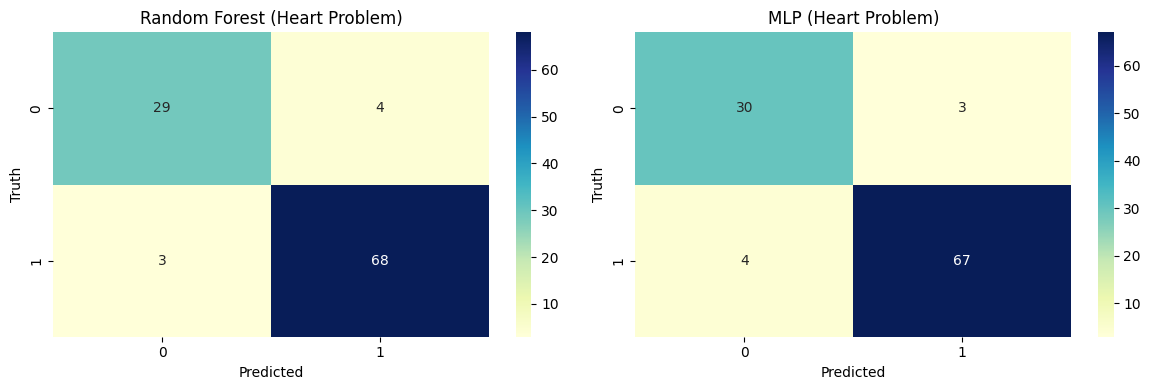

In [260]:
# confusion matrix heatmaps
fig = plt.figure(figsize = (12, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i+8])
    sns.heatmap(cm[i+8], annot = True, cmap='YlGnBu')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
plt.tight_layout()

In [261]:
# title = title[:-1]
# cm = cm[:-1]
# report = report[:-1]
title

['Random Forest Classifier',
 'Multi-Layer Perceptron',
 'Long Short-Term Memory',
 'MLP (New Features)',
 'Random Forest (Mental Health)',
 'LSTM (Mental Health)',
 'Random Forest (Jaundice)',
 'MLP (Jaundice)',
 'Random Forest (Heart Problem)',
 'MLP (Heart Problem)']